# Actor-Critic Reinforcement Learning Approach to Blackjack

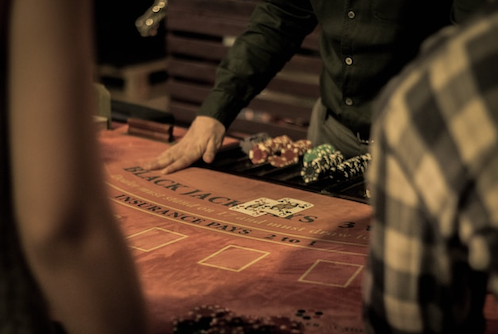

*Can AI learn to beat blackjack?*

This assignment explores the creation of an actor-critic reinforcement learning algorithm to play blackjack. Reinforcement learning algorithms are unsupervised learning algorithms in which the optimal policy is learned from rewards that are obtained from the agent’s interactions with the environment. The agent interacts with the environment and the rewards dictate the learning process. The specific reinforcement learning algorithms that we will use are further explained in their respective sections. We start by exploring basic intuitions about blackjack, the game states and actions, and how well an agent can perform. We then explore naïve solutions and a deep Q learning approach as baselines to compare our actor-critic agent against. Then, we introduce the actor-critic method, discuss the architecture, and execute it on blackjack. This is followed by a few experiments modifying the hyperparameters, and finally by discussions and conclusions.

---

**Note: The output of the code cells is stochastic so they may deviate from the exact results discussed depending on the specific execution instance.**

In [ ]:
import math
import random
import time

import gym
import numpy as np
import pandas as pd
import pygame
from pygame.locals import *
from PIL import Image
from prettytable import PrettyTable
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, concatenate
from collections import deque

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


# Blackjack and Intuition



---

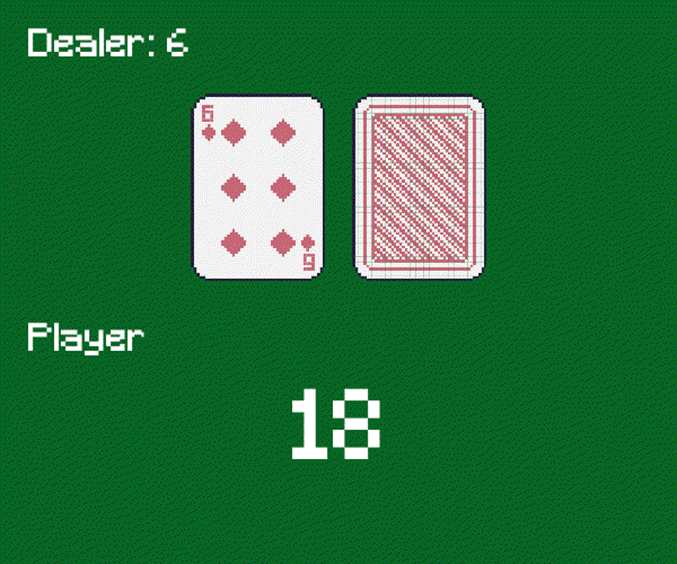

*In this assignment we focus on beating blackjack through the Open AI gym environment, with a sample state from the environment shown in the image above.*

##Rules and Overview

In this assignment, our goal is to create a reinforcement learning algorithm to play the casino game blackjack. Blackjack is a classic card game played against a dealer. In blackjack, a single player competes against the dealer, with bets being placed each round and each round typically taking a couple of seconds. Unlike poker and other card games, blackjack is a relatively simple card game with the objective of drawing cards to get as close as possible to a sum of 21 without exceeding it. To start, both the player and dealer are delt two cards, but the dealer only has one card showing. Next, the player can choose one of two actions based on their cards and the card that the dealer has showing. The player can either ‘hit’, which means to be dealt another card, or the player can choose to ‘stand’, which means to end their turn drawing cards. The players turn ends when either they choose to stand and they are happy with their current card sum, or when they exceed a sum of 21 across all their cards, which causes them to instantly loose and this is called a ‘bust’. If the player chooses to stand (does not bust), the game then goes to the dealers turn.

The dealer’s turn proceeds exactly as the players, except they will always follow a predetermined policy. Usually, this policy is to draw cards until a sum of 17 is reached and then to stand, although depending on the version and casino the sum threshold may be higher or lower. Although these are the basic rules of blackjack, some variations also allow players to double down or split. Double down means to double your original bet, take one more card, and then automatically stand. A player can split if their initial two cards are of the same rank, and they can then split them into two separate hands, each with its bet. In this assignment we will not be considering the actions of split and double down, and the only two actions are to hit or stand. Finally, the value of the cards is its face value, 10 if it is a face card (king, queen, etc.), and if you have an ace, either 11 or 1. The value of an ace can be changed from 11 to a 1 depending on your cards to get your sum as close to 21 as possible without busting, making an ace very valuable. Additionally, starting off with an ace and a 10 or face card is an instant blackjack, which in some casinos is an instant win but, in this assignment, we will still consider the dealers turn.

##Basic Strategy

Blackjack is played in nearly every casino that has table games worldwide, and non-expert players usually have basic intuition and policy for how they play. According to draft kings, the following shows some basic strategies for both when to hit and when to stand:

***When to hit***

* It is a good idea to hit when your cards add up to 11 or less. It is impossible at this point to bust, so you have nothing to lose when hitting.

* If the dealer shows a seven or higher, consider getting aggressive. As long as you have anything worse than 17, think about hitting.


***When to stand***

* If your hand is a hard 17 or higher, it is a good time to stand. It is going to be unlikely to get the small card you need if you hit in this circumstance. The odds are best for you if you stand, even if the dealer is showing a face card or ace.

* Stand when you have a hard (no ace involved) 12 or higher and the dealer shows a five or a six. A six is the worst card for a dealer, since the likelihood of them busting is highest. No matter what you have, if it is over 12, standing is going to be your best chance of coming out ahead.

However, since blackjack is a relatively simple game which is often played for high stakes at casinos, many players do not just stop there. The following sections go into more advanced card counting and mathematical approaches to blackjack.


## Card Counting

Card counting is a strategy used by some players in blackjack to gain an advantage over the casino. It involves keeping track of the ratio of high to low-value cards remaining in the deck. The idea behind card counting is that when there are more high-value cards (tens and aces) remaining in the deck, the player has a higher probability of getting a natural blackjack (a two-card hand totaling 21), and the dealer is more likely to bust. On the other hand, when there are more low-value cards, the advantage shifts towards the dealer. When card counting, multiple people often work together over many different black jack tables and use this slight advantage to make a profit, such as the infamous MIT blackjack team in the 1979 that made a small fortune in Atlantic city. Card counting is not illegal, but casinos have since employed counter measures to prevent advantage play of the player over the dealer. Many casinos now use strategies such as using multiple decks, reshuffling frequently, and monitoring player behavior. In our assignment we assume an infinite number of decks that the cards are being drawn from, meaning that card counting is not a factor that comes into play. Still, a discussion of the history of blackjack strategy and beating blackjack is not complete without mentioning the notion of card counting.

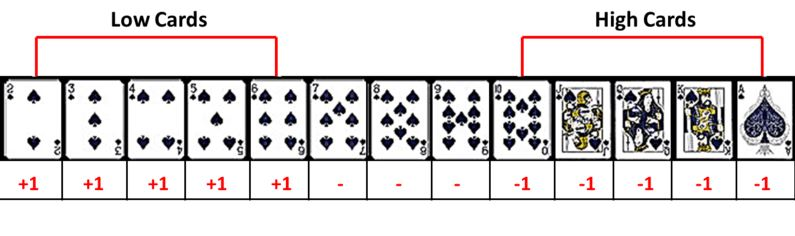

*An illustration of how card counting points are assigned.*

##Mathematical Basis

Unknown to many tourists gambling in the casinos of Las Vegas, blackjack is a mathematically solved game. This means that based on the statistics of receiving a card based on your current hand and the dealers showing card, there is a mathematically optimal action that will give you the best chance of winning the round. A full probabilistic/statistical breakdown of blackjack is beyond the scope of this assignment, however, the work done to solve blackjack by mathematicians of the 1950s and 1960s has resulted in several probability charts. As blackjack has evolved from using one deck to many different decks (with sometimes different cards removed), the probabilities of receiving certain card pairs and combinations have slightly shifted. However, some important statistics that are still relevant is that the player has a probability of around 28% of receiving a good initial hand (sum of 18, 19, 20, or 21), and that the dealer has a probability of around 28% of busting each round. Based on the mathematical probability tables, the two tables below show the optimal strategy based on the player’s hand and the dealers showing card. The first table is a general strategy table, while the second table is a strategy table when the player has a usable ace, with H meaning hit, S meaning stand, and D meaning double down. Ultimately, if these tables are used, a player has a 42.22% chance of winning according to statistical literature. Since we do not consider double down in this assignment, the optimal policy will be different in our simple blackjack example and we can just assume that double down means to hit.

**General Table**

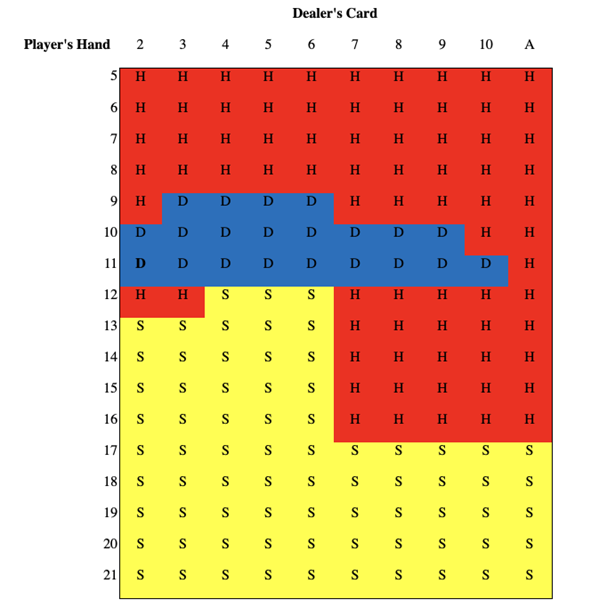

**Useable Ace Table**

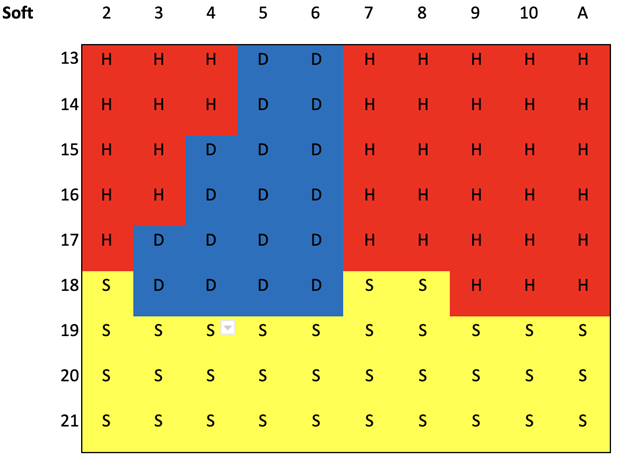

##AI Gym Environment

To simulate our blackjack environment, we used the OpenAI gym Toy Text blackjack environment. This environment has an action space of two actions (hit or stand), and an input space of 3 features (player sum, dealer card up, and if there is a usable ace). This environment is simulated with an infinite deck, and it starts with the dealer having one face up and one face down card, while the player has two face up cards. According to the documentation, the player can request additional cards (hit, action=1) until they decide to stop (stick, action=0) or exceed 21 (bust, immediate loss). After the player sticks, the dealer reveals their facedown card, and draws until their sum is 17 or greater. If the dealer goes bust, the player wins. If neither the player nor the dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21. Once a round is over, the environment can be reset and two new cards are delt to the dealer and player, resulting in a new starting state. The environment has numerous functions to display the state, implement an action, render the environment, and other useful functionality.

# Naive Models

---

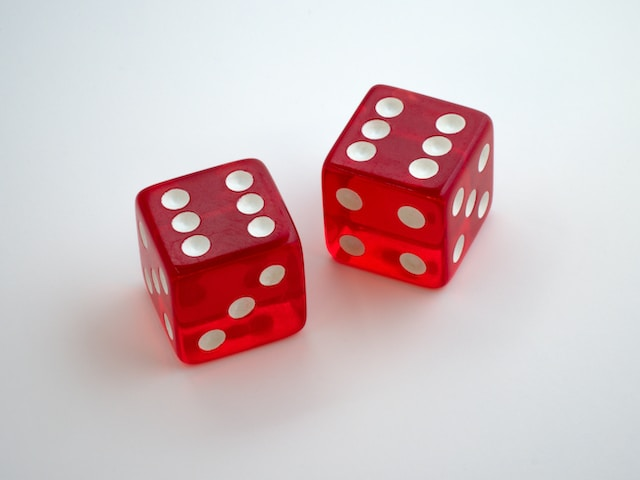

*Random policies and other basic and intuitive polices provides a good baseline to compare policies derived from our reinforcement learning algorithms.*

This section creates three naïve agents to achieve a performance baseline for comparison against. The first naïve agent always hits. This agent is expected to lose every game as the agent is required to stand before (or at 21) in order to win. If the agent always hits, it will always bust and lose. The second naïve agent always stands. This agent is expected to win around as often as the dealer is expected to bust. This is because an agent that always stands is likely to have a low sum that a dealer will beat if they do not bust. Finally, the third naïve agent picks a random action at every timestep. This agent is not expected to perform very well, but will provide a good baseline to beat for our actor-critic algorithm.

---

The code below initializes the blackjack environment using AI gym.

---


In [ ]:
seed = 42
env = gym.make('Blackjack-v1', natural=False, sab=False)
env.seed(seed);

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


---

The code below defines the three naïve agent algorithms.

---


In [ ]:
def always_hit():
  return 1

def always_stand():
  return 0

def random_action():
  return round(random.random())

---

The code below runs 100,000 games using the always hit policy and reports the percentage of games that the agent won.

---


In [ ]:
win_percentage_hit = 0
for i in range(100000):
  state = env.reset()

  while True:
    action = always_hit()
    state, reward, done, _ = env.step(action)

    if done:
      if reward == 1:
        win_percentage_hit += 1
      break

win_percentage_hit /= 100000

print("Win Percentage ", win_percentage_hit)

Win Percentage  0.0


---

The code below runs 100,000 games using the always stand policy and reports the percentage of games that the agent won.

---


In [ ]:
win_percentage_stand = 0
for i in range(100000):
  state = env.reset()

  while True:
    action = always_stand()
    state, reward, done, _ = env.step(action)

    if done:
      if reward == 1:
        win_percentage_stand += 1
      break

win_percentage_stand /= 100000

print("Win Percentage ", win_percentage_stand)

Win Percentage  0.3796


---

The code below runs 100,000 games using the random policy and reports the percentage of games that the agent won.

---


In [ ]:
win_percentage_random = 0
for i in range(100000):
  state = env.reset()

  while True:
    action = random_action()
    state, reward, done, _ = env.step(action)

    if done:
      if reward == 1:
        win_percentage_random += 1
      break

win_percentage_random /= 100000

print("Win Percentage ", win_percentage_random)

Win Percentage  0.27863


---

The code below visualizes the performance of the different naïve policies using a bar graph.

---


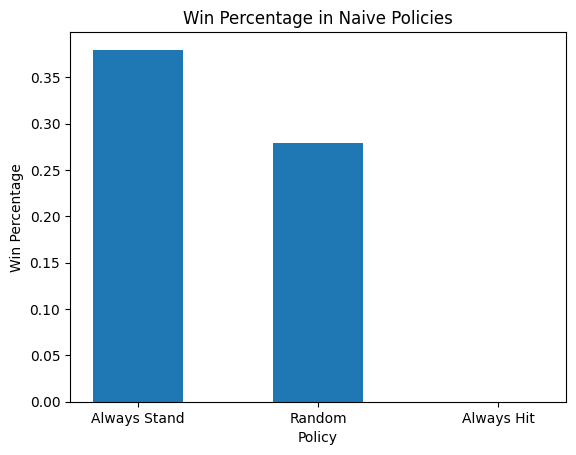

In [ ]:
number_classes = {'Always Stand': win_percentage_stand,
'Random': win_percentage_random,
'Always Hit': win_percentage_hit}

plt.bar(number_classes.keys(), number_classes.values(), width = .5);
plt.title("Win Percentage in Naive Policies");
plt.xlabel('Policy');
plt.ylabel('Win Percentage');

## Results

This section provided a baseline to compare our reinforcement learning models against. The best naïve model proved to be always stand, which had a win percentage of ~38%. We can consider our agent successful if it beats this baseline.

# Deep Q Network



---



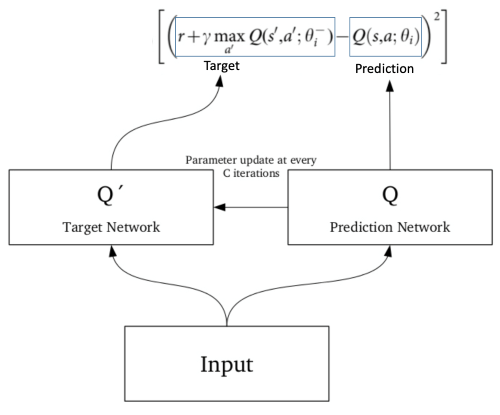

*After spending countless days designing, configuring, and tuning our actor critic network, we wanted to compare the results of that architecture against a simple deep-q network. This deep-q network is designed using a very similar network to the one used to solve the grid world in assignment 2. We run the model for 10,000 iterations, then display the resulting policy table and the win rate of the final trained model.*




This section creates and runs a deep Q-learning network as a baseline comparision against the actor critic method. The cells below contain functions that define the neural network architecture, the training process, and the main deep Q-learning function which serves as a driver for the training process. The agent_model function defines the model architecture, which is created using Keras and is used to create both the main model and the target model. The train function is used to train the main model using replay memory and the bellman equation to calculate TD error when fitting the weights of the model. Finally, the main driver main_deep_QL function is used to configure epsilon greedy learning, the number of batches, create the deque for replay memory and append different (state, action, reward, newstate) instances to the deque by making predictions on the main model, update the target model, and print the total reward each episode to show the converging process.



---



This function creates the model architecture for both the main and target networks using one input layer, two hidden layers, and a final output layer which has two output nodes, one for each action and associated Q-value.



---



In [ ]:
#Main model architecture:
#1 input layer of size 3 (player sum, dealer sum, usable ace)
#2 hidden layers of size 24 and 12 respectively
#1 output layer of size 2 (2 actions)
def agent_model():
  learning_rate = 0.001
  init = tf.keras.initializers.HeUniform()
  model = keras.Sequential()
  model.add(keras.layers.Dense(24, input_shape=(3,), activation='relu', kernel_initializer=init))
  model.add(keras.layers.Dense(12, activation='relu', kernel_initializer=init))
  model.add(keras.layers.Dense(2, activation='linear', kernel_initializer=init))
  model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=['accuracy'])
  return model





---



This function trains the main network using replay memory, and uses the target network to predict the next state's maximum Q-value. It then uses those predicted values as the labels against which compare the main model's predicted q value (emulating temporal difference), and then trains the network weights using those two values. Finally, training is done in mini batches, and the learning rate, discount factor, and batch size are all tunable hyperparameters that impact the convergence time.



---



In [ ]:
#Main training loop function
def model_train(replay_memory, model, target_model, loss_curve, model_weights, iteration, learning_rate, discount_factor):

  #Define layer sizes
  l1 = 3
  l2 = 24
  l3 = 12
  l4 = 2

  #Only train if replay memory deque is greater than 1000 instances
  if len(replay_memory) < 1000:
    return

  #Create batch for training and target network prediction
  batch_len = 128
  batch = random.sample(replay_memory, batch_len)
  curr_states = np.array([temp[0] for temp in batch])
  current_qs_list = model.predict(curr_states, verbose=0)
  new_curr_states = np.array([temp[3] for temp in batch])
  future_qs_list = target_model.predict(new_curr_states, verbose=0)

  #Use bellman equation to calculate updated Q value for main NN training
  X = []
  Y = []
  for index, (curr_state, action, reward, new_state, done) in enumerate(batch):
    if not done:
      max_future_q = reward + discount_factor * np.max(future_qs_list[index])
    else:
      max_future_q = reward

    X.append(curr_state)
    current_qs = current_qs_list[index]
    current_qs[action] = (1 - learning_rate) * current_qs[action] + learning_rate * max_future_q
    Y.append(current_qs)

  #Train the model using current state and the current_qs from bellman update
  loss = model.fit(np.array(X), np.array(Y), batch_size=batch_len, verbose=0, shuffle=True)
  loss_curve.append(loss.history['loss'])




---



This function serves as the driver for the deep-Q Learning process. The main episode control loop, epsilon greedy decay method, action selection, replay memory setup, agent moving, and target network weight updates are all done within this function. This function employs replay memory, and it copies over the main network weights to the target network every 100 agent steps. Additionally, this function takes epsilon, max and min epsilon, the decay rate, and the number of training episodes as tunable parameters.



---



In [ ]:
#Main deep Q learning driver
def main_deep_QL(epsilon, max_epsilon, min_epsilon, decay, train_episodes, env, model, target_model):

  #Setup replay memory, counter, and arrays
  replay_memory = deque(maxlen=50_000)
  target_update_counter = 0
  steps_to_update_target_model = 0
  loss_curve = []
  total_training = []
  model_weights = []
  for i in range((2*24 + 24*12 + 12*2)):
    model_weights.append([])

  #Main loop for each episode
  for episode in range(train_episodes):
    total_training_rewards = 0
    curr_state = env.reset()
    done = False
    steps_in_episode = 0

    #While the agent has not reached the goal
    while done != True:
        steps_to_update_target_model += 1
        steps_in_episode = steps_in_episode + 1

        #Get best predicted action or epsilon greedy action
        random_number = np.random.rand()
        if random_number <= epsilon:
          action = env.action_space.sample()
        else:
          encoded = list(curr_state)
          encoded = np.array(curr_state)
          encoded_reshaped = encoded.reshape([1, encoded.shape[0]])
          predicted = model.predict(encoded_reshaped, verbose = 0).flatten()
          action = np.argmax(predicted)

        #Get the reward and associated new state after doing the action
        new_state, reward, done, _ = env.step(action)

        #Store current instance into the replay memory
        replay_memory.append([curr_state, action, reward, new_state, done])

        #Train model using the replay memory bank every 4 iterations
        if steps_to_update_target_model % 4 == 0 or done:
          model_train(replay_memory, model, target_model, loss_curve, model_weights, steps_to_update_target_model, 0.7, 0.9)

        #Update current state and total training rewards
        curr_state = new_state
        total_training_rewards += reward

        #Print statements at the end of the episode
        if done:
          if (episode % 1000 == 0):
            print('Total training rewards: {} after n episodes = {} with final reward = {}'.format(total_training_rewards, episode, reward))
          total_training.append(total_training_rewards)

          #Copy over main to target model weights
          if steps_to_update_target_model >= 100:
            target_model.set_weights(model.get_weights())
            steps_to_update_target_model = 0
          break

    #Epsilon decay
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)

  #Return the loss, model weights, and total training arrays for plotting
  return loss_curve, total_training, model_weights


---

The code below initializes the model, hyperparameters, and blackjack environment.

---


In [ ]:
#Setting a random seed for model initializer
RANDOM_SEED = 15
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

#Create agent and environment objects
env = gym.make('Blackjack-v1', natural=False, sab=False)
state = env.reset()

#Create main and target models
model = agent_model()
target_model = agent_model()
target_model.set_weights(model.get_weights())

#Define hyperparameters
epsilon = 1
max_e = 1
min_e = 0.01
decay = 0.005
episodes = 10000

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


---

The code below utilizes the main deep Q-learning function to train the model and recieve the loss values.

---

In [ ]:
#Call driver to start the training process
loss, reward_per_e, model_weights = main_deep_QL(epsilon, max_e, min_e, decay, episodes, env, model, target_model)

Total training rewards: -1.0 after n episodes = 0 with final reward = -1.0
Total training rewards: 1.0 after n episodes = 1000 with final reward = 1.0
Total training rewards: 1.0 after n episodes = 2000 with final reward = 1.0
Total training rewards: 0.0 after n episodes = 3000 with final reward = 0.0
Total training rewards: 0.0 after n episodes = 4000 with final reward = 0.0
Total training rewards: -1.0 after n episodes = 5000 with final reward = -1.0
Total training rewards: -1.0 after n episodes = 6000 with final reward = -1.0
Total training rewards: 0.0 after n episodes = 7000 with final reward = 0.0
Total training rewards: 1.0 after n episodes = 8000 with final reward = 1.0
Total training rewards: 1.0 after n episodes = 9000 with final reward = 1.0


---

The code below displays the loss curve of training the main neural network model. The graph shows a downward and eventually converging trend, showing convergence in the training process.

---


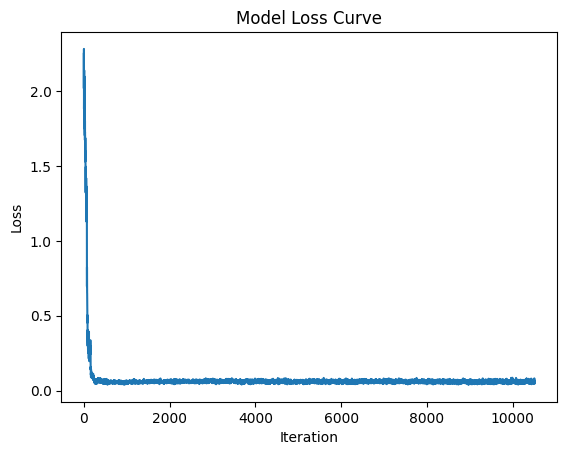

In [ ]:
#Plot the Loss Curve
plt.plot(loss)
plt.title('Model Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

---

The cell bellow outputs the blackjack policy table based on the trained model.

---


In [ ]:
table = PrettyTable()

# Set column names
table.field_names = ['Player ↓ | Dealer →'] + [str(i) for i in range(1, 11)]

# Populate the table
for i in range(2, 22):
    action_array = []
    for j in range(1, 11):
        encoded = list((i, j, False))
        encoded = np.array(encoded)
        encoded_reshaped = encoded.reshape([1, encoded.shape[0]])
        # Assuming 'model' is defined somewhere in your code
        predicted = model.predict(encoded_reshaped, verbose=0).flatten()
        action = np.argmax(predicted)
        action_array.append(action)

    # Add a row to the table
    table.add_row([str(i)] + action_array)

# Print the table
print(table)

+---------------------+---+---+---+---+---+---+---+---+---+----+
| Player ↓ | Dealer → | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
+---------------------+---+---+---+---+---+---+---+---+---+----+
|          2          | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1  |
|          3          | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1  |
|          4          | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1  |
|          5          | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1  |
|          6          | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1  |
|          7          | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1  |
|          8          | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1  |
|          9          | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1  |
|          10         | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1  |
|          11         | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1  |
|          12         | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1  |
|          13         | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1  |
|          14         | 1

---

The section bellow empirically calculates the win rate of the agent based on actions predicted by the trained model.

---


In [ ]:
number_of_wins = 0
for i in range(1000):
  state = env.reset()
  done = False
  # Loop through the game until it's finished
  while not done:
    encoded = state
    encoded = np.array(encoded)
    encoded_reshaped = encoded.reshape([1, encoded.shape[0]])
    predicted = model.predict(encoded_reshaped, verbose = 0).flatten()
    action = np.argmax(predicted)
    next_state, reward, done, _ = env.step(action)
    state = next_state
  if reward == 1:
    number_of_wins = number_of_wins + 1

In [ ]:
print("Win Percentage ", number_of_wins/1000)

Win Percentage  0.392


##Results

This section provides an alternate solution to compare the performance of our actor-critic method. This deep-Q network is based on the codebase used for our gridworld assignment 2, and as such we know that the architecutre is proven to work. When initially experimenting with the actor-critic method, we had a difficult time tuning parameters and configuring the architecture, so we decided to compare it to a simple yet proven deep-Q network as a baseline. Overall, the deep-Q network performed surprisingly well, achiving a near optimal win percentage and a black jack policy table that is very near the mathematicaly determined optimal table. Additionally, the loss curve very clearly shows convergence in the training process to the (near) optimal policy. As you will see in the next section, the simple deep Q-network created a policy table closer to optimal than the actor-critic method with much less tuning and complex configuration required. The win rate was also very close to the actor critic network, but this fluctuates with each run of the predictions/simulations since we only used 1,000 simulations due to time/RAM constraints.

# Actor-Critic Method

---

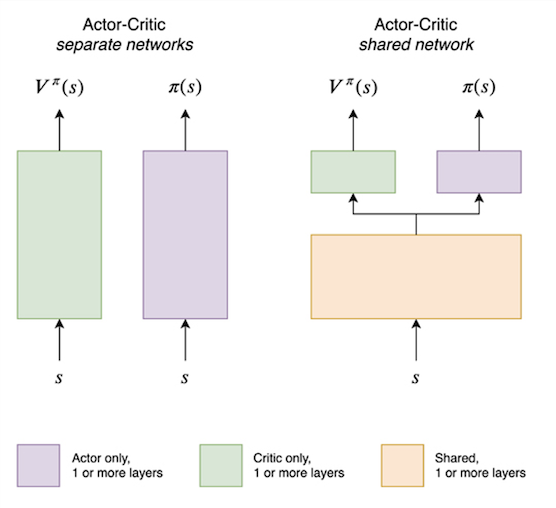

*The implementation of the actor critic algorithm in this notebook utilized a shared actor-critic network.*

The actor-critic method utilizes aspects of both value-based reinforcement learning methods and policy-based methods. Value based methods include Q-learning while policy-based methods include Monte Carlo. In the actor critic method, there are two networks: the actor and the critic network. The actor network provides action probabilities while the critic network approximates the value function. The actor is updated based on the difference between the expected cumulative reward and the estimated value provided by the critic. The critic is updated based on the difference between the predicted value and the actual observed cumulative reward. The advantage of the actor-critic method is that it is more sample efficient, and it can handle both discrete and continuous action spaces, which are features that other algorithms do not have.

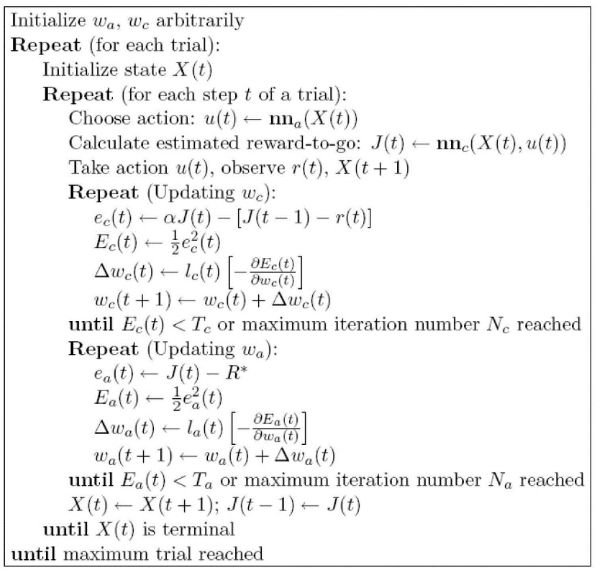

*The pseudocode above shows the actor-critic method. In our implementation, we used Keras to handle the neural network details, however, the same basic algorithm is at play.*

In this specific implementation of the actor-critic algorithm, the agent plays a complete game of blackjack using epsilon greedy exploration. The final reward is then used to calculate the actual observed cumulative reward for each state, which is used to update the actor and the critic. The critic is updated using the huber loss of the actual return vs the estimated return while the actor is updated using the product of the difference between the two and the negative log probability of the action taken. This allows the actor to learn to prefer actions that led to higher rewards. Additionally, the neural network architecture uses a common hidden layer and a common input layer, but separate output layers. The critic utilizes a dense layer with a linear activation while the actor utilizes a dense layer with a softmax activation. This is because the actor solves a binary “classification” problem while the critic solves a regression problem. The hidden layer has 128 neurons. This shared architecture implementation is based on the official Keras implementation of the actor critic method for the cart-pole environment. The network can also be separated into two networks; however, this architecture seems to be prevalently used in many examples of actor critic networks. When the loss is backpropagated  for training, the actor and critic losses are added together due to the shared network. Additionally, during forwards propagation, the network outputs two separate vectors, one for action probabilities and one for the value estimation.

---

The code below defines functions that help initialize the parameters, environment, and neural network for the actor critic algorithm. The initialize configuration function initializes hyperparameters and seeds the random number generators. The create blackjack environment function creates a blackjack gym environment. Finally, the build model function defines the actor-critic neural network architecture using the number of inputs, action, and hidden layers as inputs.

---

In [ ]:
# Parameters
def initialize_configuration():
    global seed, gamma, max_steps_per_episode, epsilon, max_epsilon, min_epsilon, decay

    # Seeding Random Number Generators
    seed = 654321
    np.random.seed(seed=seed)
    tf.keras.utils.set_random_seed(seed)

    # Discount factor
    gamma = 0.99
    max_steps_per_episode = 10

    # Exploration parameter for epsilon-greedy strategy
    epsilon = 1
    max_epsilon = 1
    min_epsilon = 0.01
    decay = 0.0030

# Create Blackjack environment
def create_blackjack_env():
    env = gym.make("Blackjack-v1")
    env.seed(seed)
    return env

# Build neural network model
def build_model(num_inputs, num_actions, num_hidden):
    # Define the neural network architecture
    inputs = layers.Input(shape=(num_inputs,))
    common = layers.Dense(num_hidden, activation="relu", name='hidden_layer')(inputs)
    action = layers.Dense(num_actions, activation="softmax")(common)
    critic = layers.Dense(1)(common)
    model = keras.Model(inputs=inputs, outputs=[action, critic])
    return model

---

The code below defines helper functions that help the training process in the main actor critic function. The first function helps calculate rewards given the reward history of an episode. The second function normalizes the returns, and the last function calculates the actor and critic losses.

---

In [ ]:
# Helper functions

# Calculates returns
def calculate_returns(rewards_history):
    returns = []
    discounted_sum = 0
    for r in rewards_history[::-1]:
        discounted_sum = r + gamma * discounted_sum
        returns.insert(0, discounted_sum)
    return returns

# Normalizes returns
def normalize_returns(returns, eps):
    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
    return returns.tolist()

# Calculates losses
def calculate_losses(action_probs_history, critic_value_history, returns, huber_loss):
    actor_losses = []
    critic_losses = []
    history = zip(action_probs_history, critic_value_history, returns)
    for log_prob, value, ret in history:
        diff = ret - value
        actor_losses.append(-log_prob * diff)
        critic_losses.append(
            huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
        )
    return actor_losses, critic_losses

---

The code below defines the main training loop for the actor critic algorithm. The code plays a game of blackjack using an epsilon greedy method and records the rewards. It then calculates the returns and losses based on one complete episode and utilizes these to backpropagate and train the network. The actor network returns the action probabilities while the critic network returns the value of the state. The training process is repeated for a given number of episodes with the losses being printed every 1000. Finally, the trained model, losses, and weights are returned.



---

In [ ]:
# Training loop
def train_model(model, optimizer, huber_loss, max_episodes=10000):
    global epsilon
    action_probs_history = []
    critic_value_history = []
    rewards_history = []
    episode_count = 0
    losses = []
    weights = []
    eps = np.finfo(np.float32).eps.item()

    while episode_count < max_episodes:
        state = env.reset()
        episode_reward = 0

        with tf.GradientTape() as tape:
            for timestep in range(1, max_steps_per_episode):
                # Prepare the state for input to the neural network
                state = tf.convert_to_tensor(state)
                state = tf.expand_dims(state, 0)

                # Get predictions from the network
                # using the current state
                action_probs, critic_value = model(state)
                critic_value_history.append(critic_value[0, 0])

                # Epsilon-greedy action selection
                if np.random.rand() < epsilon:
                    action = np.random.choice(2)
                else:
                    action = np.argmax(action_probs)

                action_probs_history.append(tf.math.log(action_probs[0, action]))

                # Execute the action in the environment
                state, reward, done, _ = env.step(action)

                rewards_history.append(reward)
                episode_reward += reward

                if done:
                    break

            # Calculate returns from reward history
            returns = calculate_returns(rewards_history)

            # Normalize the returns
            returns = normalize_returns(returns, eps)

            # Calculate losses
            actor_losses, critic_losses = calculate_losses(
                action_probs_history, critic_value_history, returns, huber_loss
            )

            # Backpropagate to train networks
            loss_value = sum(actor_losses) + sum(critic_losses)
            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            weights.append(model.get_layer('hidden_layer').get_weights())
            losses.append(loss_value)

            # Clear history
            action_probs_history.clear()
            critic_value_history.clear()
            rewards_history.clear()

        # Print log
        episode_count += 1
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode_count)
        if episode_count % 1000 == 0:
            template = "Loss: {:.2f} at episode {}"
            print(template.format(loss_value, episode_count))

    return model, losses, weights

---


The code below trains the actor critic network using a learning rate of 0.0001 over 10,000 iterations.


---

In [ ]:
initialize_configuration()
env = create_blackjack_env()
model = build_model(num_inputs=3, num_actions=2, num_hidden=128)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
huber_loss = keras.losses.Huber()

trained_model, losses, weights = train_model(model, optimizer, huber_loss)

/usr/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


Loss: -0.24 at episode 1000
Loss: -0.23 at episode 2000
Loss: -0.19 at episode 3000
Loss: -0.21 at episode 4000
Loss: 0.03 at episode 5000
Loss: -0.06 at episode 6000
Loss: -0.23 at episode 7000
Loss: -0.22 at episode 8000
Loss: -0.22 at episode 9000
Loss: -0.20 at episode 10000


---

The code below prints the policy table derived from the trained model.

---

In [ ]:
table = PrettyTable()

# Define column names
table.field_names = ['Player ↓ | Dealer →'] + [str(card) for card in range(1, 11)]

# Populate the table
for i in range(2, 22):
    action_array = []
    for j in range(1, 11):
        state = list((i, j, False))
        state = tf.convert_to_tensor(state)
        state = tf.expand_dims(state, 0)
        action_probs, _ = trained_model(state)
        action = np.argmax(action_probs)
        action_array.append(action)

    # Add a row to the table
    table.add_row([i] + action_array)

# Print the table
print(table)

+---------------------+---+---+---+---+---+---+---+---+---+----+
| Player ↓ | Dealer → | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
+---------------------+---+---+---+---+---+---+---+---+---+----+
|          2          | 1 | 1 | 1 | 1 | 1 | 0 | 0 | 0 | 0 | 0  |
|          3          | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 0 | 0  |
|          4          | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1  |
|          5          | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1  |
|          6          | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1  |
|          7          | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1  |
|          8          | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1  |
|          9          | 1 | 1 | 1 | 0 | 1 | 0 | 0 | 0 | 1 | 1  |
|          10         | 1 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 1  |
|          11         | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0  |
|          12         | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0  |
|          13         | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0  |
|          14         | 0

---

The code below prints the loss curve based on the training process.

---

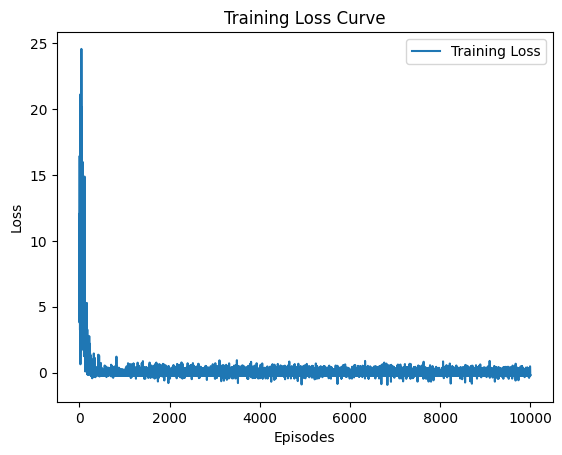

In [ ]:
# Plots the loss curve
plt.plot(losses, label='Training Loss')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

---

The code below samples six weights and plots their trajectories.

---

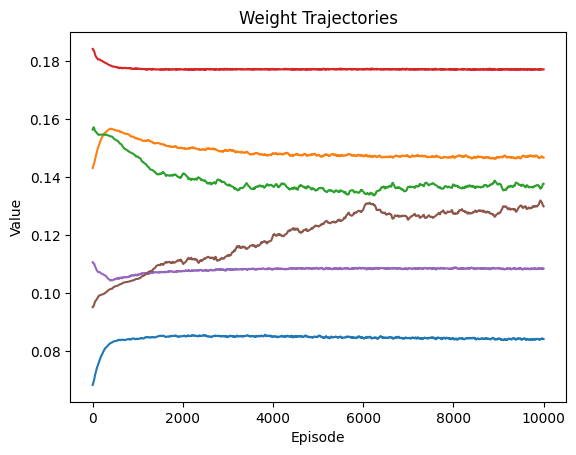

In [ ]:
weight_1 = []
for i in range(len(weights)):
  weight_1.append(weights[i][0][0][0])

weight_2 = []
for i in range(len(weights)):
  weight_2.append(weights[i][0][1][0])

weight_3 = []
for i in range(len(weights)):
  weight_3.append(weights[i][0][2][20])

weight_4 = []
for i in range(len(weights)):
  weight_4.append(weights[i][0][0][20])

weight_5 = []
for i in range(len(weights)):
  weight_5.append(weights[i][0][1][20])

weight_6 = []
for i in range(len(weights)):
  weight_6.append(weights[i][0][2][0])

plt.plot(weight_1)
plt.plot(weight_2)
plt.plot(weight_3)
plt.plot(weight_4)
plt.plot(weight_5)
plt.plot(weight_6)
plt.title('Weight Trajectories')
plt.ylabel('Value')
plt.xlabel('Episode')
plt.show()

---

The code below plots the trajectory of one of the previous six weights.

---

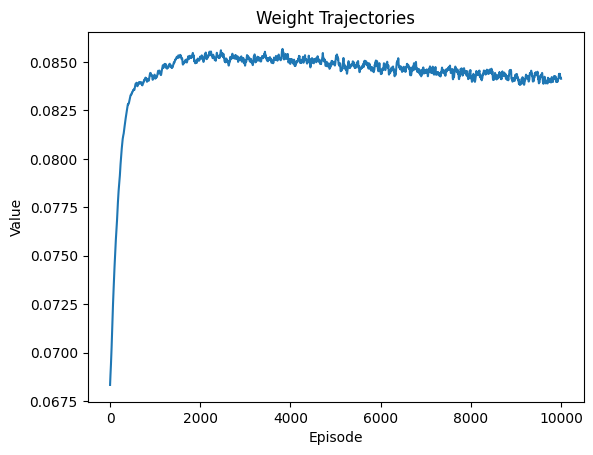

In [ ]:
plt.plot(weight_1)
plt.title('Weight Trajectories')
plt.ylabel('Value')
plt.xlabel('Episode')
plt.show()

---

The code below plays 10,000 games of blackjack based on the model’s policy and reports the percentages of games won.

---

In [ ]:
# Finds the win percentage
win_percentage_AC = 0
for i in range(10000):
  state = env.reset()

  while True:

    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)

    action_probs, __ = trained_model(state)
    action = np.argmax(action_probs)

    state, reward, done, _ = env.step(action)

    if done:
      if reward == 1:
        win_percentage_AC += 1
      break

win_percentage_AC /= 10000

print("Win Percentage ", win_percentage_AC)

Win Percentage  0.3883


## Results

Overall, the actor critic network displayed indications of convergence in the loss curve and the weight trajectories. In the beginning of training, the loss was high, which then reduced overtime to a steady line near zero (a degree of fluctuation is caused by the stochasticity of blackjack). This decreasing loss curve is a characteristic of networks that have converged to a policy. Furthermore, upon inspecting the trajectories of six sample weights, it can be seen that they changed significantly in the beginning of training, but then stabilized towards the end. This is another indication of network convergence. The plot of one weight alone better shows this trend with the weight stabilizing at the end of the training process.

The policy table indicates that the agent learned a part of the basic strategy for blackjack but has yet to fully converge. The table tells the agent to hit on low sums, stand at high sums, and hit when the dealer has a high sum, and the agent has a moderate sum. This matches the general idea of the basic strategy table. The win percentage supports this idea as the agent achieved ~40% win rate compared to a always stand win percentage of 38% found in the naïve agents section. This suggests that the agent has learned a strategy that is better than the best naïve baseline.

# Experiments

---

This section explores some experiments that modify the hyperparameters of the actor critic model to observe their effect on model performance. The initial development of the model proved to be difficult due to hyperparameter tuning, so these experiments may provide further insight as to how sensitive the model is to changes in hyperparameter settings.

## Changing Learning Rate

---

The cells below train the actor critic network using a higher learning rate for 1,000 episodes and plot the loss curve.

---

In [ ]:
initialize_configuration()
env = create_blackjack_env()
model = build_model(num_inputs=3, num_actions=2, num_hidden=128)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
huber_loss = keras.losses.Huber()

trained_model, losses, weights = train_model(model, optimizer, huber_loss, max_episodes=1000)

Loss: nan at episode 1000


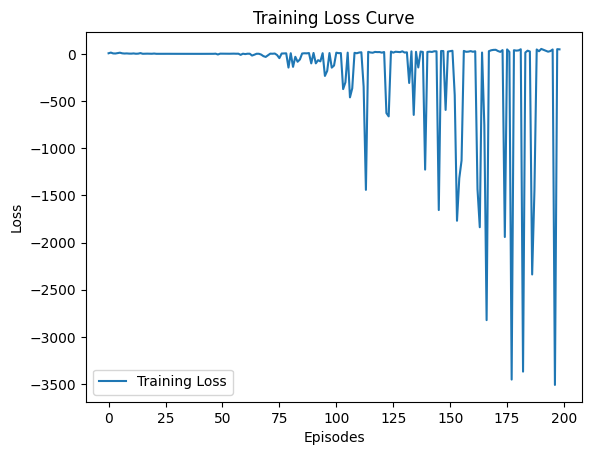

In [ ]:
# Plots the loss curve
plt.plot(losses, label='Training Loss')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

---

The cells below train the actor critic network using a lower learning rate for 1,000 episodes and plot the loss curve and policy table.

---

In [ ]:
initialize_configuration()
env = create_blackjack_env()
model = build_model(num_inputs=3, num_actions=2, num_hidden=128)
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
huber_loss = keras.losses.Huber()

trained_model, losses, weights = train_model(model, optimizer, huber_loss, max_episodes=1000)

Loss: 2.05 at episode 1000


In [ ]:
table = PrettyTable()

# Define column names
table.field_names = ['Player ↓ | Dealer →'] + [str(card) for card in range(1, 11)]

# Populate the table
for i in range(2, 22):
    action_array = []
    for j in range(1, 11):
        state = list((i, j, False))
        state = tf.convert_to_tensor(state)
        state = tf.expand_dims(state, 0)
        action_probs, _ = trained_model(state)
        action = np.argmax(action_probs)
        action_array.append(action)

    # Add a row to the table
    table.add_row([i] + action_array)

# Print the table
print(table)

+---------------------+---+---+---+---+---+---+---+---+---+----+
| Player ↓ | Dealer → | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
+---------------------+---+---+---+---+---+---+---+---+---+----+
|          2          | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0  |
|          3          | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0  |
|          4          | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0  |
|          5          | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0  |
|          6          | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0  |
|          7          | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0  |
|          8          | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0  |
|          9          | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0  |
|          10         | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0  |
|          11         | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0  |
|          12         | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0  |
|          13         | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0  |
|          14         | 0

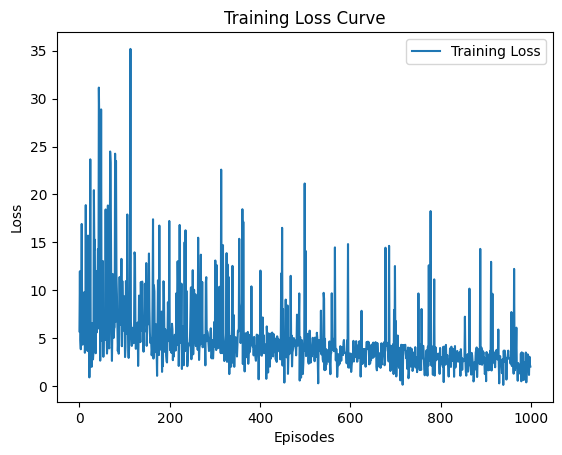

In [ ]:
# Plots the loss curve
plt.plot(losses, label='Training Loss')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

## Changing Iterations

---

The cells below train the actor critic network for 1,000 iterations using the original hyperparameter settings and displays the loss curve, policy table, and win rate.

---

In [ ]:
initialize_configuration()
env = create_blackjack_env()
model = build_model(num_inputs=3, num_actions=2, num_hidden=128)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
huber_loss = keras.losses.Huber()

trained_model, losses, weights = train_model(model, optimizer, huber_loss, max_episodes=1000)

Loss: -0.24 at episode 1000


In [ ]:
table = PrettyTable()

# Define column names
table.field_names = ['Player ↓ | Dealer →'] + [str(card) for card in range(1, 11)]

# Populate the table
for i in range(2, 22):
    action_array = []
    for j in range(1, 11):
        state = list((i, j, False))
        state = tf.convert_to_tensor(state)
        state = tf.expand_dims(state, 0)
        action_probs, _ = trained_model(state)
        action = np.argmax(action_probs)
        action_array.append(action)

    # Add a row to the table
    table.add_row([i] + action_array)

# Print the table
print(table)

+---------------------+---+---+---+---+---+---+---+---+---+----+
| Player ↓ | Dealer → | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
+---------------------+---+---+---+---+---+---+---+---+---+----+
|          2          | 1 | 1 | 1 | 1 | 0 | 0 | 0 | 0 | 0 | 0  |
|          3          | 1 | 1 | 1 | 1 | 1 | 0 | 0 | 0 | 0 | 0  |
|          4          | 0 | 1 | 0 | 1 | 1 | 1 | 1 | 0 | 0 | 0  |
|          5          | 0 | 0 | 0 | 0 | 1 | 1 | 1 | 1 | 1 | 0  |
|          6          | 0 | 0 | 0 | 0 | 0 | 1 | 1 | 1 | 1 | 1  |
|          7          | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 1 | 1 | 1  |
|          8          | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 1 | 1 | 1  |
|          9          | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 1 | 1  |
|          10         | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 1  |
|          11         | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 1  |
|          12         | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0  |
|          13         | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0  |
|          14         | 0

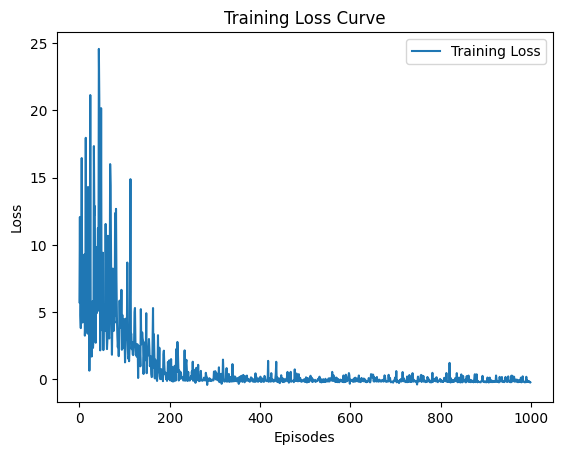

In [ ]:
# Plots the loss curve
plt.plot(losses, label='Training Loss')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

In [ ]:
# Finds the win percentage
win_percentage_AC = 0
for i in range(1000):
  state = env.reset()

  while True:

    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)

    action_probs, __ = trained_model(state)
    action = np.argmax(action_probs)

    state, reward, done, _ = env.step(action)

    if done:
      if reward == 1:
        win_percentage_AC += 1
      break

win_percentage_AC /= 1000

print("Win Percentage ", win_percentage_AC)

Win Percentage  0.378


---

The cells below train the actor critic network for 5,000 iterations using the original hyperparameter settings and displays the loss curve, policy table, and win rate.

---

In [ ]:
initialize_configuration()
env = create_blackjack_env()
model = build_model(num_inputs=3, num_actions=2, num_hidden=128)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
huber_loss = keras.losses.Huber()

trained_model, losses, weights = train_model(model, optimizer, huber_loss, max_episodes=5000)

Loss: -0.24 at episode 1000
Loss: -0.23 at episode 2000
Loss: -0.19 at episode 3000
Loss: -0.21 at episode 4000
Loss: 0.03 at episode 5000


In [ ]:
table = PrettyTable()

# Define column names
table.field_names = ['Player ↓ | Dealer →'] + [str(card) for card in range(1, 11)]

# Populate the table
for i in range(2, 22):
    action_array = []
    for j in range(1, 11):
        state = list((i, j, False))
        state = tf.convert_to_tensor(state)
        state = tf.expand_dims(state, 0)
        action_probs, _ = trained_model(state)
        action = np.argmax(action_probs)
        action_array.append(action)

    # Add a row to the table
    table.add_row([i] + action_array)

# Print the table
print(table)

+---------------------+---+---+---+---+---+---+---+---+---+----+
| Player ↓ | Dealer → | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
+---------------------+---+---+---+---+---+---+---+---+---+----+
|          2          | 1 | 1 | 1 | 1 | 0 | 0 | 0 | 0 | 0 | 0  |
|          3          | 1 | 1 | 1 | 1 | 1 | 1 | 0 | 0 | 0 | 0  |
|          4          | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 0 | 0 | 0  |
|          5          | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 0  |
|          6          | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1  |
|          7          | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1  |
|          8          | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1  |
|          9          | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1  |
|          10         | 1 | 1 | 0 | 1 | 1 | 1 | 1 | 1 | 1 | 1  |
|          11         | 0 | 0 | 0 | 0 | 0 | 1 | 1 | 1 | 1 | 1  |
|          12         | 0 | 0 | 0 | 0 | 0 | 1 | 1 | 1 | 1 | 1  |
|          13         | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 1 | 1 | 1  |
|          14         | 0

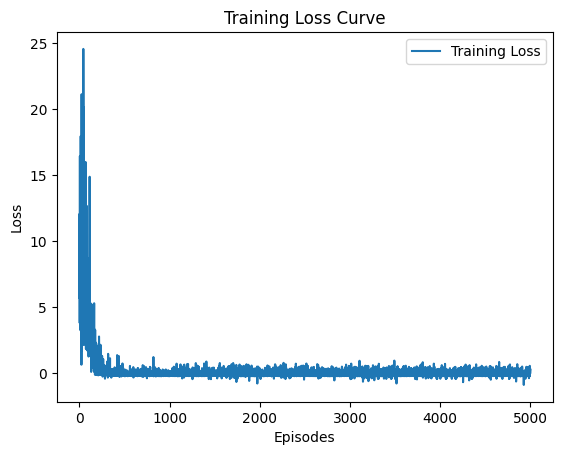

In [ ]:
# Plots the loss curve
plt.plot(losses, label='Training Loss')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

In [ ]:
# Finds the win percentage
win_percentage_AC = 0
for i in range(1000):
  state = env.reset()

  while True:

    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)

    action_probs, __ = trained_model(state)
    action = np.argmax(action_probs)

    state, reward, done, _ = env.step(action)

    if done:
      if reward == 1:
        win_percentage_AC += 1
      break

win_percentage_AC /= 1000

print("Win Percentage ", win_percentage_AC)

Win Percentage  0.419


## Results

The first set of experiments showed the importance of selecting a proper learning rate. A learning rate that is too low creates diverging weights due to steps that are too large in the direction of the gradient. This creates NaN values that propagate through the network. This can be seen in the first changing learning rate experiment with a learning rate of 0.001. The loss curve shows how rather than a decreasing loss, there is an increasing loss due to diverging weights. The second experiment in the changing learning rates experiment section highlights the effects of a learning rate that is too low. With a learning rate of 0.00001, the weights move very slowly and take a long time to converge. This is highlighted by the low slope of the loss curve. While the loss curve is minimizing overtime, it does so very slowly due to the very low learning rate. The problem of proper learning rate selection was very frustrating in the initial development of the model.

The second set of experiments showed that there may be an “overfitting” – like effect that is occurring in the network. Too little iterations (1,000) results in a decreased win percentage and a policy table that looks less like blackjack basic strategy. However, at half of the original iterations (5,000), the policy table has a greater resemblance to the blackjack basic strategy table and has a better win percentage than the original actor critic network. The network may be overfitting to stochasticity in the environment or there may be a sub-optimality due to the exploration-exploitation tradeoff strategy that is causing this effect. Regardless, it seems that training the agent for 5,000 iterations is better than training it for more iterations. All three (1,000, 5,000, and 10,000 iterations) have similar loss curve that indicate complete convergence, which is interesting given the observation previously discussed.  

# Discussions and Conclusions

---

This section discusses and analyzes the outcomes of the actor critic Q-learning training process, focusing
on the training process as well as convergence trends seen in the error, total returns, and neural network weights curves.

##Results Discussion, Convergence, and Graphs

The actor critic network was successfully able to beat blackjack and produce a close to optimal policy. After running the network with the optimal hyperparameters determined from countless experiments, we were able to achieve a model that had a policy close to the mathematically optimal black jack tables. Since blackjack has a mathematically derived maximum win rate of 42.22% for the player, we technically did not ‘beat’ black jack but we were able to produce a win rate of 41.9% based on 1,000 simulations, which is very close to playing optimally. This is further shown by the decreasing and stable loss curve, as well as the weight graphs, both of which show the convergence of the model. After printing the blackjack policy table, the model generally learned to hit when the sum is 10 or less, and after 10, hit only when the dealer has a showing card that was increasingly close to 10. This is similar to the trends shown in the optimal tables, which also show a staggering trend of always hitting up to 10, and then only hitting if the dealer has a 7 or more showing up to a player sum of 16. Interestingly, the model’s learned policy table did not suggest hitting on sums of 2 through 5 if the dealer had a high card showing. This may be due to a lack of convergence, or that during the training process the dealer had the highest chance of starting with a good wining hand and thus the agent losing regardless of their action if they had a high card showing. However, since the player sum is low in this situation optimal policy dictates getting another card, which the agent may have eventually learned given enough episodes. We also implemented naïve policy versions of always standing, randomly hitting/standing, and always hitting. Always standing produced the highest naïve win rate of 38%, showing that our algorithm improved upon the baseline (although also surprisingly that just standing produces a relatively high win rate to start). Thus, our actor critic architecture was successfully able to come very close to the optimal policy required to ‘beat’ blackjack and achieve the optimal win rate.

##Efficiency, Experiments, and Deep-Q Learning Experiments

When tuning with the actor critic architecture, we experimented with the learning rate, the number of training iterations, and the reward values. For the learning rate, we tried learning rates of 0.001, 0.00001, and 0.001. The higher learning rate resulted in NAN values for the loss since the model was moving too quickly in the direction of the weight update, causing it to pass through and away from the optimum and eventually overshoot/fail to converge. This is shown by the increasing loss curve. On the other hand, the lower learning rate caused the model to update so slowly towards the optimum that it did not yet converge, as shown by the decreasing but still noisy and relatively high learning curve. The learning rate of 0.001 was optimal in our case, producing the clearest loss curve that shows convergence. Next, we changed the number of episodes to 1,000 and 5,000. As anticipated, 1,000 episodes was not enough for the model weights to converge, resulting in a decreasing but still noisy loss curve and a blackjack action table policy that could still be improved. 5,000 episodes resulted in a much more clear loss curve, and a blackjack action table policy very close to the optimal. Of all the tuning parameters attempted, 5,000 iterations at a learning rate of 0.001 produced the highest win rate of 41.9%, which is very close to the optimal literature value of 42.22% if played according to the mathematical blackjack tables.


Interestingly enough, the network was very sensitive to the weight initialization, and we had to find a seed that prevented the network from falling into the local optima of all zeros. The untuned network almost always found the local optima of all zeros, which produces an empirically determined 38% accuracy. This accuracy is relatively close to the optimal 42% found when playing by the mathematically determined blackjack table, meaning it was difficult for the network to get out of this local optima without some hyperparameter experimentation. Initially, the reward for busting was -1, winning was 1, and all else was zero. To encourage the agent to hit (instead of just always standing and finding the local optimum policy of always standing), we added a slight reward for getting a card without busting. This initially worked to find a policy which involved the agent opting to hit at lower sums. However, we realized that the single largest factor in achieving a better policy was the learning rate. After experimenting with the learning rate for many different runs, we finally found one that produced a much closer to optimal policy, irrespective of the slight hit incentive. Interestingly enough, the number of training iterations also had a large impact on the policy, with the best policy being produced at an intermediate number of iterations (5,000) rather than the higher number 10,000 initially attempted. Overall, it took days to finally get the models to produce a policy that was not the local optimum of always standing. During the first few tuning attempts, we also created a deep Q-network to compare the results to see how the policies compared. Notably, the deep Q-network created a policy table very close to the mathematically derived black jack table with very little tuning and relatively fast training time. This leads us to conclude that for a simple game like blackjack with only 2 actions, a small input space, and a relatively low win rate if played optimally, a deep Q-network may be a better fit. The added complexity of the actor critic network may have resulted in greater difficulty converging to the optimal policy without extensive tuning and experimentation in this situation.


##Real Life Applications and Meaning

This assignment first and foremost demonstrates that blackjack is a difficult game to make a profit on in a casino. Even if playing optimally, the win rate will not exceed around 42%, meaning that odds are if you play long enough you will lose your money. If you decide to play blackjack at a casino, your best bet at making a profit (or at least not losing too much money) is to quit playing as soon as you made some profit or quit playing as soon as you are below a certain amount of money lost. Although at first glance players may think that blackjack is more fair than other casino games since both the player and dealer follow the same rules and draw from the same deck probabilities, this is not the case. Since the player must go first and has a chance of busting (and thus instantly loosing) even before the dealer’s turn, the house has an innate advantage over the player, and even if played optimally by following the mathematically derived blackjack cheat table, players have an increased chance of loosing money. Both the actor critic and deep Q networks confirmed a similar win rate and policy table to the mathematically calculated win rate, showing the blackjack is essentially a terrible casino game to play if you are looking to make money (like every other casino game against the house). You are much better off playing a game against other opponents, such as poker, where the house does not have an innate advantage and all players are at a fair starting point.

##Final Thoughts

Overall, this assignment showed us how reinforcement learning can be applied to real life applications and projects. Up to this point, we have been using Q learning and deep Q-learning to beat the small scale and relatively arbitrary problem of grid world. However, when we think about reinforcement learning, algorithms such as Deep Blue and Alpha Zero often come to mind. These algorithms made headlines by beating high profile chess and go players, and this assignment comes closer to the spirit of those powerful and famous algorithms. Aside from showing us how reinforcement learning can be applied to real life problems, this assignment also demonstrated the sensitive nature of utilizing an actor critic network for blackjack. Finding the correct combination of hyperparameters for the loss curve to correctly converge took days of experimentation, and many times we were convinced that it was a problem with our architecture. On the other hand, the simple deep Q-network we implemented solved the problem with a close to optimal win rate much more efficiently and without extensive tuning. Clearly, in the case of black jack, the simple action and observation space lend themselves better to a deep-Q network than the more complex actor critic network. However, working through the actor critic tuning process helped us better understand neural network integrated reinforcement learning, as well as the (frustrating) tuning process and the limitations of actor critic in different contexts.

# References

---

The following sources were used in the creation of this assignment.

* https://casino.draftkings.com/blackjack-strategy

* https://en.wikipedia.org/wiki/MIT_Blackjack_Team

* https://www.gymlibrary.dev/environments/toy_text/blackjack/

* https://probability.infarom.ro/blackjack.html

* https://keras.io/examples/rl/actor_critic_cartpole/

* http://www.jstor.org/stable/170849

* https://mrq.com/blog/blackjack-odds
